# Homework 3

You can submit in groups of 2. Due 3/25, 1pm.
All assignments need to be submitted via github classroom:
https://classroom.github.com/g/yCXet19l
and as PDF via gradescope.
The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of the assignment to identify promising features, models and preprocessing methods and apply them as appropriate.
The overall goal is to predict the price of a used vehicle on craigslist, as can be found on kaggle:  https://www.kaggle.com/austinreese/craigslist-carstrucks-data
You can find a description of the dataset and download it from there. You do not have to use the whole dataset, and it’s recommended that you strongly subsample the data while developing your solution.
While the modelling process is likely iterative, please lay out the following tasks in the given order to facilitate grading.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### Set global sklearn configuration

In [0]:
import sklearn

sklearn.set_config(print_changed_only=True)

### Craigslist Used Car Dataset: Load and Sub-Sample



In [0]:
master_df = pd.read_csv('/content/drive/My Drive/kaggle_datasets/vehicles.csv')

In [0]:
sub_sample_df = master_df.sample(10000, random_state=42)

## Task 1 Identify Features

### Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? Are there any features that should be excluded because they leak the target information? Show visualizations or statistics to support your selection. You are not required to use the description column, but you can try to come up with relevant features using it. Please don’t use bag-of-word approaches for now as we’ll discuss these later in the class.

### Exploratory Data Analysis

In [0]:
columns_to_drop = ['id', 'url', 'vin', 'image_url', 'region_url', 'description', 'lat', 'long', 'county']

df = sub_sample_df.drop(columns_to_drop, axis=1)

The dropped columns--id, url, vin, image_url, region_url, description, lat, long, county--are dropped because they either leak information to the target variable (e.g., id, vin), are too particular to specific listings (image_url, region_url, url), or are redundant (lat, long, county).

In [6]:
df['price'].value_counts()

0        909
3500      95
5995      94
8995      89
6995      84
        ... 
10906      1
10745      1
20990      1
10898      1
29749      1
Name: price, Length: 2198, dtype: int64

In [7]:
print(f'Only {len(df[df["price"] > 1e5])} outlier cars priced above $100,000')

Only 5 outlier cars priced above $100,000


### Drop outlier prices: 0s and >100,000

In [0]:
df = df[df['price'] < 1e5]

indexes = df[df['price'] == 0].index

df = df.drop(indexes)

### Visualize numerical features


In [9]:
categorical = df.dtypes == object

numerical = ~categorical

numerical

region          False
price            True
year             True
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer         True
title_status    False
transmission    False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool

### Plot numerical features before removing outliers

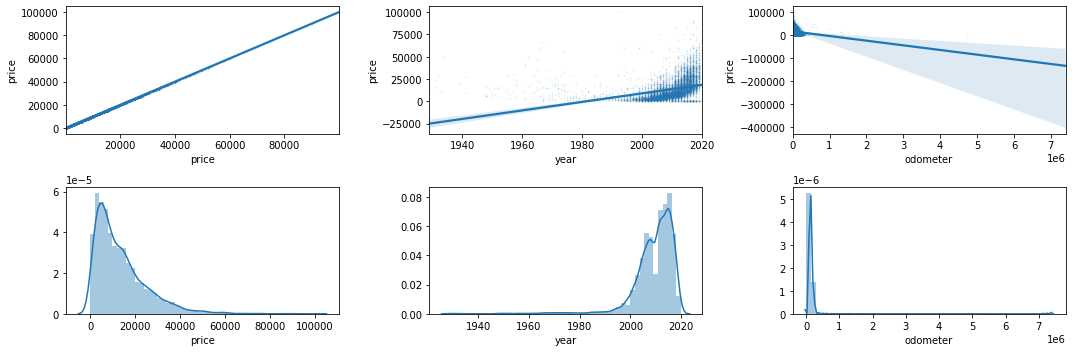

In [10]:
fig, ax = plt.subplots(2,3,figsize=(15,5))

for i, feature in enumerate(df.columns[numerical]):
  sns.regplot(df[feature], df['price'], ax=ax[0,i], scatter_kws={'alpha': 0.1, 's': 0.5})
  sns.distplot(df[feature], ax=ax[1,i])
  
plt.tight_layout()

### Remove outliers for better visualizations

In [11]:
print(f'Number of cars with odometer readings greater than {3e5}:', len(df[df['odometer'] > 3e5]))

print(f'Numer of cars sold that were made before 1950:', len(df[df['year'] < 1950]))

Number of cars with odometer readings greater than 300000.0: 60
Numer of cars sold that were made before 1950: 19


In [0]:
df = df[df['odometer'] <= 3e5]

df = df[df['year'] >= 1950]

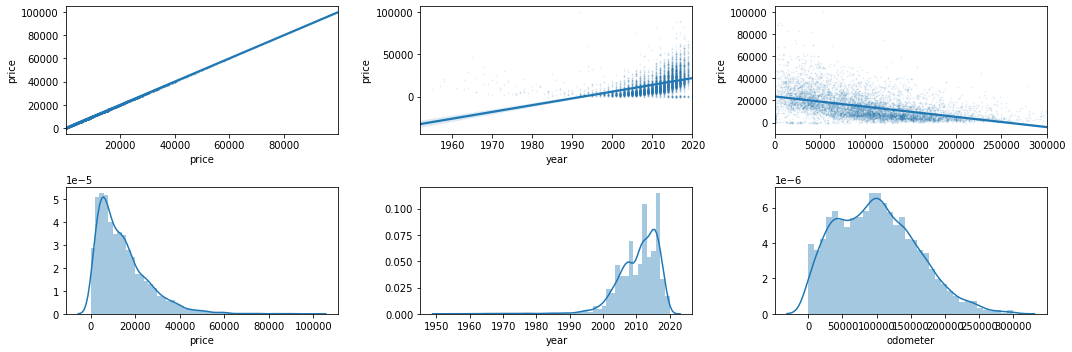

In [13]:
fig, ax = plt.subplots(2,3,figsize=(15,5))

for i, feature in enumerate(df.columns[numerical]):
  sns.regplot(df[feature], df['price'], ax=ax[0,i], scatter_kws={'alpha': 0.1, 's': 0.5})
  sns.distplot(df[feature], ax=ax[1,i])
  
plt.tight_layout()

After cleaning the data slightly so that outlier variables were removed from the numerical features (including the target feature, "price"), it's clear that there is a positive correlation between year and price (meaning the newer the car, the higher the price) and a negative correlation between odometer reading and price (meaning the higher the odometer reading, the lower the price).

As for the histogram graphs, price shows a positive skew towards higher numbers, which makes sense since 0 is a hard cap on how low price can be, while there is effectively no cap on price. With regard to year, you can see a clustering that ranges from 2000 to present, and then a significant tail towards the earlier years in the 1900s. Odometer had a very balanced distribution, with the data clustering from 0 all the way to 200,000, which is usually the mileage around which cars begin to break down. So this all makes sense.

### Bar plots of categorical variables

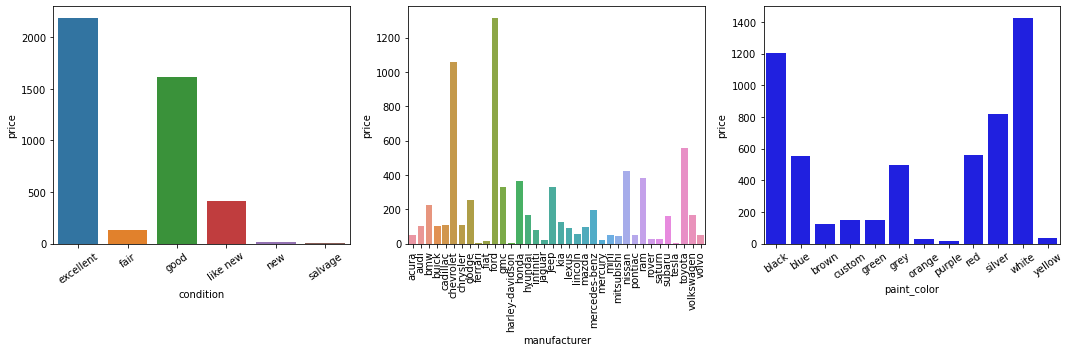

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

# Plot 1

x_tmp = df.groupby('condition')['price'].count().index

y_tmp = df.groupby('condition')['price'].count()

sns.barplot(x_tmp, y_tmp, ax=ax[0])

ax[0].set_xticklabels(x_tmp, rotation=35)

# Plot 2

x_tmp = df.groupby('manufacturer')['price'].count().index

y_tmp = df.groupby('manufacturer')['price'].count()

sns.barplot(x_tmp, y_tmp, ax=ax[1])

ax[1].set_xticklabels(x_tmp, rotation=90)

# Plot 3

x_tmp = df.groupby('paint_color')['price'].count().index

y_tmp = df.groupby('paint_color')['price'].count()

sns.barplot(x_tmp, y_tmp, ax=ax[2], color='b')

ax[2].set_xticklabels(x_tmp, rotation=35)

plt.tight_layout()

The first bar plot above shows that most craigslist sales involve "excellent" and "good" cars, while "like new" and "fair" have a smaller but noticeable portion of the sales, and "new" and "salvage" are essentially negligible. "New" makes sense as negligible since new cars probably aren't being sold on Craigslist, and if they are it would be rare.

The second plot shows that certain manufacturers such as Ford, Chevrolet, and Toyota sell the most cars, but other manufacturers such as Ram, Nissan, Jeep, Honda, and GMC also have a fair portion of the total market. Certain brands like Alfa-Romeo and Datsun make up close to 0 sales individually.

The third plot shows that the most commonly sold cars are white followed by black, silver, and blue in that order. Very few sold cars are purple, yellow, or orange, which could indicate that people don't prefer those colors and/or that there are not that many of those cars being offered in the marketplace.

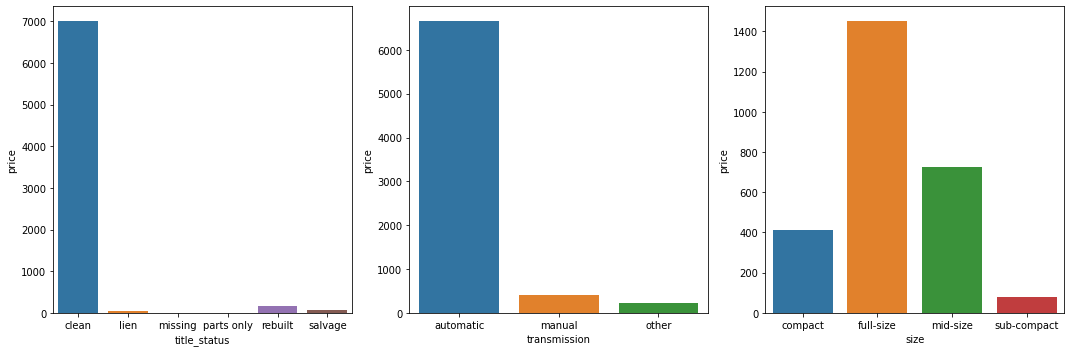

In [15]:
dicfig, ax = plt.subplots(1,3, figsize=(15,5))

# Plot 1

x_tmp = df.groupby('title_status')['price'].count().index

y_tmp = df.groupby('title_status')['price'].count()

sns.barplot(x_tmp, y_tmp, ax=ax[0])

# Plot 2

x_tmp = df.groupby('transmission')['price'].count().index

y_tmp = df.groupby('transmission')['price'].count()

sns.barplot(x_tmp, y_tmp, ax=ax[1])

# Plot 3

x_tmp = df.groupby('size')['price'].count().index

y_tmp = df.groupby('size')['price'].count()

sns.barplot(x_tmp, y_tmp, ax=ax[2])

plt.tight_layout()

The first plot shows that the vast majority of sold cars have clean title, which makes sense since buyers don't want to buy cars with issues involving title (i.e., who owns the car).

The second plot shows that the vast majority of sold cars are automatic transmissions. Manual transmissions make up a small but visible minority.

The third bar plot shows that full-size cars reign supreme on craigslist, but mid-size and compact cars also have a good portion of the market. Sub-compact cars have a sliver of the total market.

## Task 2 Preprocessing and Baseline Model
### Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset.

### Baseline Model

In [0]:
df = df.reset_index(drop=True)

In [0]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)

y = df['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD

numerical_cols = X.dtypes != object

categorical_cols = ~numerical_cols

numerical_preprocessor = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler())

categorical_preprocessor = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer((numerical_preprocessor, numerical_cols), (categorical_preprocessor, categorical_cols))

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

pipe = make_pipeline(preprocessor, LinearRegression()).fit(X_train, y_train)

score = cross_val_score(pipe, X_train, y_train, cv=5)

print(f'Train cv score: {np.mean(score)}')

print(f'Val score: {pipe.score(X_val, y_val)}')

Train cv score: 0.5070513375043604
Val score: 0.5534923542470049


## Task 3 Feature Engineering
### Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables and whether adding interactions (for example using PolynomialFeatures or manually) might help.

In [20]:
X = df.drop('price', axis=1)

y = df['price']

numerical_cols = X.dtypes != object

categorical_cols = ~numerical_cols

X.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,albany,2016.0,toyota,tundra,NaN,8 cylinders,gas,50305.0,clean,automatic,4wd,NaN,pickup,black,ny
1,"st louis, MO",2003.0,ford,escape xlt 4x4,excellent,6 cylinders,gas,184000.0,clean,automatic,4wd,NaN,SUV,blue,il
2,watertown,2015.0,ford,escape se 4x4,like new,4 cylinders,gas,95909.0,clean,automatic,4wd,full-size,SUV,blue,ny
3,elmira-corning,2012.0,gmc,NaN,like new,8 cylinders,gas,47700.0,clean,automatic,4wd,full-size,truck,black,ny
4,san antonio,2017.0,chevrolet,traverse,NaN,NaN,gas,74268.0,clean,automatic,NaN,NaN,NaN,NaN,tx


### Investigate the number of unique values per column

In [21]:
for column in X.columns[categorical_cols]:

  print(f'{column}: {len(X[column].value_counts())}')

region: 377
manufacturer: 36
model: 2575
condition: 6
cylinders: 8
fuel: 5
title_status: 6
transmission: 3
drive: 3
size: 4
type: 13
paint_color: 12
state: 51


### Feature engineering: 'Model'

Removing models that have limited appearances in the dataset will help mitigate overfitting. So we need to find a suitable threshold that eliminates infrequently appearing models while also not removing so many that valuable information is lost.

In [0]:
X['model'].fillna('unk', inplace=True)

model_value_counts = pd.DataFrame(X['model'].value_counts())

model_counts = []

for company in X['model']:

  count = model_value_counts.loc[company, 'model']

  model_counts.append(count)

X['model_counts'] = model_counts

In [23]:
print('Ratio of model_counts less than 2:', len(X[X['model_counts'] < 2]) / len(X))

Ratio of model_counts less than 2: 0.2429893819765859


Deleting any car model that has fewer than 2 total instances will drastically reduce number of one-hot encoded features (by 24.3% to be precise), thus making our model more streamlined and efficient.


In [24]:
bool_mask = X['model_counts'] < 2

X['model'].loc[bool_mask] = 'unk'

X = X.drop('model_counts', axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Feature engineering: 'Region'

Similar to the feature selection for models, we want to remove regions that appear infrequently.

In [0]:
X['region'].fillna('unk', inplace=True)

region_value_counts = pd.DataFrame(X['region'].value_counts())

region_counts = []

for region in X['region']:

  count = region_value_counts.loc[region, 'region']

  region_counts.append(count)

X['region_counts'] = region_counts

In [26]:
print('Ratio of regions less than 10:', len(X[X['region_counts'] < 10]) / len(X))

Ratio of regions less than 10: 0.0917506125782739


Since only a little over 9% of the regions appear fewer than 10 times, we'll go ahead and replace all of those regions with 'unk' so we can further reduce dimensionality of infrequent occurences. We could raise the threshold and further remove regions, but removing too many regions runs the risk of being overly restrictive and casting away valuable information for our machine learning model.

In [27]:
bool_mask = X['region_counts'] < 10

X['region'].loc[bool_mask] = 'unk'

X = X.drop('region_counts', axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Combine state and region categories, since almost all regions are specific to a certain state.

In other words, there's no point in having regions (which are uniuqe to specific states, typically although not always) and states as separate categories. Further, we don't want to just use regions and not states, as some regions do fall on the border between states (see Kansas City, MO/KS, for example), nor do we want to just use states as this will be unnecessarily broad and less informative than using regions which are more granular.

This process of combining the two features will further help reduce dimensionality so that one-hot encoding does not blow up the feature space.

In [0]:
comb_state_region = []

for state, region in zip(X['state'], X['region']):

  comb = state + ' ' + region

  comb_state_region.append(comb)

X['comb_region'] = comb_state_region

X = X.drop(['state', 'region'], axis=1)

### PolynomialFeatures

Polynomial Features is being used to add an interaction term that's the result of the two numerical features ('year' and 'odometer') being multiplied together.

In [0]:
from sklearn.preprocessing import PolynomialFeatures

pol_feats = PolynomialFeatures(2, interaction_only=True)

transformed_cols = pol_feats.fit_transform(X[['year', 'odometer']])

X['year_x_odo'] = transformed_cols[:,3]

In [30]:
X.head()

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,comb_region,year_x_odo
0,2016.0,toyota,tundra,NaN,8 cylinders,gas,50305.0,clean,automatic,4wd,NaN,pickup,black,ny albany,101414880.0
1,2003.0,ford,escape xlt 4x4,excellent,6 cylinders,gas,184000.0,clean,automatic,4wd,NaN,SUV,blue,"il st louis, MO",368552000.0
2,2015.0,ford,unk,like new,4 cylinders,gas,95909.0,clean,automatic,4wd,full-size,SUV,blue,ny unk,193256635.0
3,2012.0,gmc,unk,like new,8 cylinders,gas,47700.0,clean,automatic,4wd,full-size,truck,black,ny unk,95972400.0
4,2017.0,chevrolet,traverse,NaN,NaN,gas,74268.0,clean,automatic,NaN,NaN,NaN,NaN,tx san antonio,149798556.0


## Task 4 Any model
### Use any classification model we discussed (trees, forests, gradient boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate.

In [0]:
X = X.reset_index(drop=True)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

### Preprocessing

1) Imputing missing values. For numerical features, by using each feature's median; for categorical features, by using an arbitrary string constant.

2) Scaling numerical features with MinMaxScaler so that each feature's values range from 0 to 1.

3) Target Encode each categorical feature so that each category is given a value based on its mean response in the target variable, smoothed by the global mean of the target variable.

In [33]:
! pip install category_encoders

     |████████████████████████████████| 102kB 1.3MB/s 


In [0]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_cols = X_train.dtypes != object

categorical_cols = ~numerical_cols

numerical_preprocessor = Pipeline(steps=[('numericalimputer', SimpleImputer(strategy='median')),
                                         ('minmaxscaler', MinMaxScaler())])

categorical_preprocessor = Pipeline(steps=[('categoricalimputer', SimpleImputer(strategy='constant')),
                                           ('onehotencoder', TargetEncoder(handle_unknown='ignore')),
                                           ('categoricalimputer2', SimpleImputer(strategy='constant'))])

preprocessor = ColumnTransformer(transformers=[('numerical', numerical_preprocessor, numerical_cols),
                                               ('categorical', categorical_preprocessor, categorical_cols)], remainder='passthrough')

### Model 1: Lasso Regression

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

pipe = Pipeline(steps=[('preprocessor', preprocessor), ('lasso', Lasso())])

param_grid = {'lasso__alpha': np.logspace(0,2,3)}

grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train)

print(f'Best params:', grid.best_params_)

print(f'Train cv score: {max(grid.cv_results_["mean_test_score"])}')

Best params: {'lasso__alpha': 1.0}
Train cv score: 0.3866327639117676


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362858433.4529419, tolerance: 75813087.3240341
  positive)


### Model 2: Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(preprocessor, RandomForestRegressor())

scores = cross_val_score(pipe, X_train, y_train, cv=5)

print(f'Train cv score: {np.mean(scores)}')

Train cv score: 0.6648431994411179


### Model 3: Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

pipe = make_pipeline(preprocessor, GradientBoostingRegressor(n_estimators=100, warm_start=True))

param_grid = {'gradientboostingregressor__learning_rate': np.logspace(-3,0,4)}

grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train)

print(f'Best params: {grid.best_params_}')

print(f'Train cv score: {max(grid.cv_results_["mean_test_score"])}')

Best params: {'gradientboostingregressor__learning_rate': 0.1}
Train cv score: 0.6636131457964083


### Model 4: Support Vector Regressor

In [39]:
from sklearn.svm import LinearSVR

pipe = make_pipeline(preprocessor, LinearSVR())

param_grid = {'linearsvr__C': np.logspace(-1,3,5)}

grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train)

print(f'Best params: {grid.best_params_}')

print(f'Train cv score: {max(grid.cv_results_["mean_test_score"])}')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Best params: {'linearsvr__C': 1000.0}
Train cv score: -0.1528875020308616


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Task 5 Feature Selections
### Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better? (This will be discussed in the lecture on 03/04).

In [42]:
from sklearn.ensemble import RandomForestRegressor

X_train_proc = preprocessor.fit_transform(X_train, y_train)

clf = RandomForestRegressor().fit(X_train_proc, y_train)

scores = cross_val_score(clf, X_train_proc, y_train, cv=5)

print(f'Train cv score: {np.mean(scores)}')

X_val_proc = preprocessor.transform(X_val)

print(f'Validation score: {clf.score(X_val_proc, y_val)}')

Train cv score: 0.6677861365701192
Validation score: 0.6886743354877283


### If OHE: Get Feature Names

In [0]:
list_feat_names = ['year', 'odometer', 'year_x_odo']

for i in range(12):

  feature_list = preprocessor.transformers_[1][1].named_steps['onehotencoder'].categories_[i].tolist()

  for item in feature_list:

    list_feat_names.append(item)

## Plot Feature Importances

In [0]:
coefs = clf.feature_importances_

feature_tuples = list(enumerate(X_train.columns))

sorted_indices, sorted_values = np.argsort(coefs)[::-1], sorted(coefs, reverse=True)

sorted_features = []

for index in sorted_indices:
  for i, feature in feature_tuples:
    if index == i:
      sorted_features.append(feature)

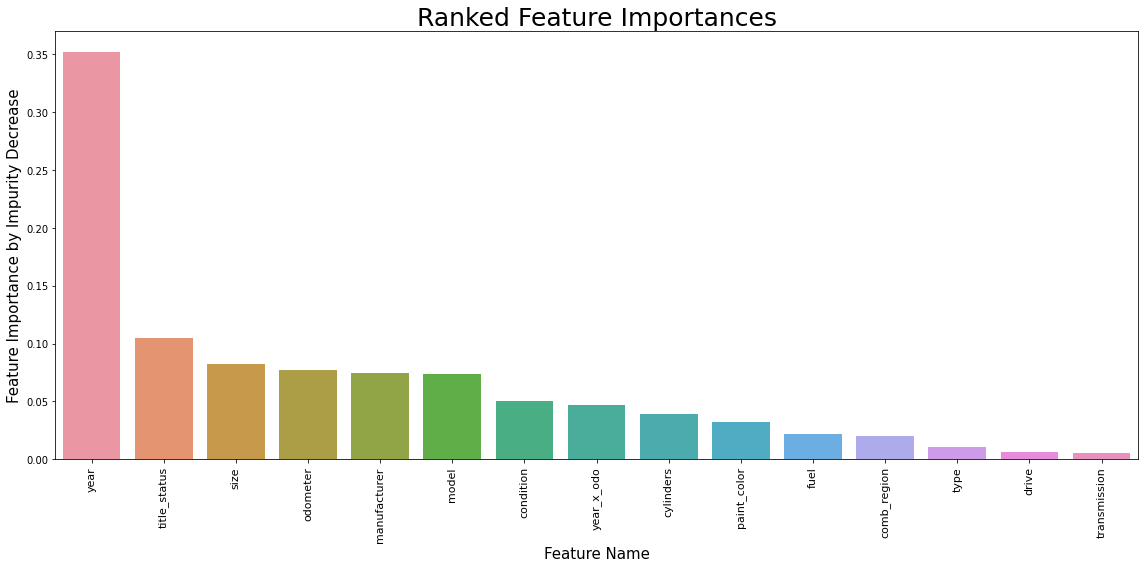

In [44]:
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(list(range(len(coefs))), sorted_values, ax=ax)

ax.set_xticklabels(sorted_features, rotation=90, size=11)

ax.set_title('Ranked Feature Importances', size=25)

ax.set_xlabel('Feature Name', size=15)

ax.set_ylabel('Feature Importance by Impurity Decrease', size=15, rotation=90)

plt.tight_layout()

The above plot illustrates the feature importances (calculated as the decrease in node impurity), beginning with 'year' on the left (the most important feature) and running rightward to 'transmission' on the far right. 'Year' makes sense as the most important feature since the older a car gets the more its expected value drops on average. We would expect, on average, for older cars to be predicted to be worth less than newer cars.

The second- and third-most important features, 'title_status' and 'size', have feature importances that are each less than a third the total feature importance of 'year'. What this means is that, although each are important features, the age of a car is clearly the best single determinant for the predicted value of a used car on Craigslist. Other important features include 'manufacturer', 'odometer', and 'model'.

The next step will be to remove the least relevant features. We will select the 10 most important features, and see how the model performs.

### Build New Model that Removes Unimportant Features


In [46]:
from sklearn.feature_selection import SelectKBest, f_regression

pipe = make_pipeline(preprocessor, SelectKBest(f_regression, k=10), RandomForestRegressor()).fit(X_train, y_train)

scores = cross_val_score(pipe, X_train_proc, y_train, cv=5)

print(f'Train cv score: {np.mean(scores)}')

print(f'Validation score: {pipe.score(X_val, y_val)}')

Train cv score: 0.637191385214127
Validation score: 0.677479178079865


Removing the five least important features dropped the validation score slightly from 68.9% to 67.7%. That's not insignificant but it's also not a devastating drop, considering we dropped 1/3 of the original features. The result is encouraging because it means those features really didn't carry that much value for the model.

## Task 6 An explainable model
### Can you create an “explainable” model that is nearly as good as your best model?
### An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonably look at all of them, or a tree with a small number of leaves etc.

In [48]:
from sklearn.linear_model import LinearRegression

X_train_proc = preprocessor.fit_transform(X_train, y_train)

clf = LinearRegression().fit(X_train_proc, y_train)

scores = cross_val_score(clf, X_train_proc, y_train)

print(f'Train CV score: {np.mean(scores)}')

X_val_proc = preprocessor.transform(X_val)

print(f'Validation score: {clf.score(X_val_proc, y_val)}')

Train CV score: 0.39467822870789654
Validation score: 0.4275367236234279


### Rank Coefficients by Value

In [0]:
coef_values = clf.coef_

coef_names = X_train.columns

sorted_indices, sorted_coef_values = np.argsort(coef_values)[::-1], sorted(coef_values, reverse=True)

sorted_coef_names = []

for index in sorted_indices:
  for i, coef_name in enumerate(coef_names):
    if index == i:
      sorted_coef_names.append(coef_name)

### Rank Coefficients by Abs Value

In [0]:
f = lambda x: abs(x)

abs_coef_values = f(coef_values)

abs_sorted_indices, abs_sorted_coef_values = np.argsort(abs_coef_values)[::-1], sorted(abs_coef_values, reverse=True)

abs_sorted_coef_names = []

for index in abs_sorted_indices:
  for i, coef_name in enumerate(coef_names):
    if index == i:
      abs_sorted_coef_names.append(coef_name)

### Graph Coefficients

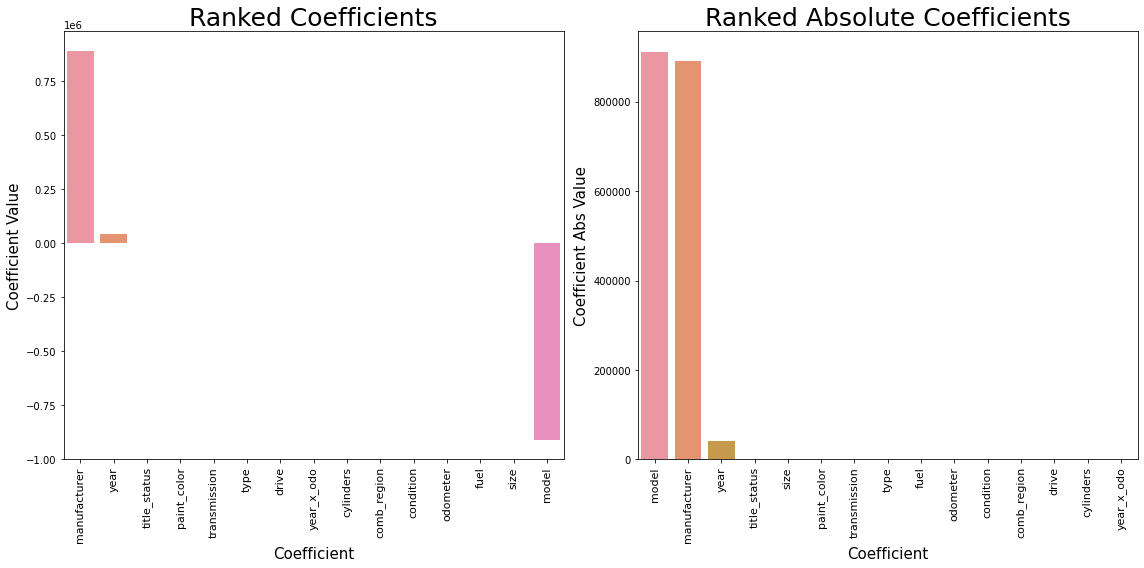

In [51]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

sns.barplot(list(range(len(coef_values))), sorted_coef_values, ax=ax[0])

ax[0].set_xticklabels(sorted_coef_names, rotation=90, size=11)

ax[0].set_title('Ranked Coefficients', size=25)

ax[0].set_xlabel('Coefficient', size=15)

ax[0].set_ylabel('Coefficient Value', size=15, rotation=90)

sns.barplot(list(range(len(coef_values))), abs_sorted_coef_values, ax=ax[1])

ax[1].set_xticklabels(abs_sorted_coef_names, rotation=90, size=11)

ax[1].set_title('Ranked Absolute Coefficients', size=25)

ax[1].set_xlabel('Coefficient', size=15)

ax[1].set_ylabel('Coefficient Abs Value', size=15, rotation=90)

plt.tight_layout()

The explainable model is a linear regression with a lower R2 score than the best model. As you can see in the graph on the right (which ranks coefficients based on absolute value), the most important coefficients are 'model' and 'manufacturer'. The only other significant coefficient is 'year', which is well behind 'model' and 'manufacturer' in coefficient value. The rest of the coefficients are too small to appear on the graph, meaning they are essentially negligible. 'Manufacturer' and 'year' have positive coefficients, meaning that as their values go up, the predicted price goes up on average. 'Model', however, has a negative coefficient, which means that it had the opposite effect of its target encoding. In other words, models that were target-encoded with higher values than others actually had the effect of predicting average values less than their other target-encoded counterparts. That was a very curious result, but it was clearly offset by the strong positive coefficient of 'manufacturer'.

It's surprising that 'year' didn't have as large of an impact as in other models, but it appears that certain manufacturers and models were hugely important to this linear model, while year was less important.